# Fuzzy Conjunctions

This section aims to show that Fuzzy Logic architectures are adept at learning conjunctions (and disjunctions) as a subset of the problem of learning general boolean functions using neurosymbolic methods.

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src')) # include top level package in python path

In [2]:
import torch
from model.fuzzy_layer import FuzzyUnsignedConjunction, FuzzyUnsignedDisjunction
from model.fuzzy_logic import ProductLogic, MinimumLogic, LukasiewiczLogic, SchweizerSklarLogic
from model.bool_logic import BoolLogic
from plot import gauss_filter
from cache import FileCacher
from tqdm.notebook import tqdm

logic = BoolLogic()
cacher = FileCacher('./conjunction_grads/')

We begin by defining our training distribution, which will be a distribution over $N$ variables, each of which being independently sampled from a Bernoulli distribution $\textsf{Ber}(0.5)$, i.e. we evenly sample points from the boolean hypercube $\{0,1\}^N$.

In [3]:
from torch.utils.data import Dataset, DataLoader, RandomSampler

class BinaryDataset(Dataset):
    def __init__(self, shape, N):
        self.samples = torch.distributions.bernoulli.Bernoulli(
            0.5
        ).sample(
            torch.Size([N, *shape])
        ).bool()
        
    def __len__(self):
        return self.samples.size(0)
    
    def __getitem__(self, idx):
        return self.samples[idx]

Here we define a dataset of 1024 samples with $N=10$. We will sample over the dataset 10,000 times per epoch, with replacement.

In [4]:
ds = BinaryDataset([10], 10_000)
ds = BinaryDataset([10], 1_000)
sampler = RandomSampler(ds, replacement=True, num_samples=100_000)
loader = DataLoader(ds, batch_size=128, sampler=sampler)

We want to learn membership $W$ of a conjunction. To generate conjunctions, we again sample elements of the boolean hypercube $\{0,1\}^N$ to encode the corresponding membership set. A conjunction with membership set $|W|=D$ will be satisfied with probability $2^{-D}$ over evenly distributed boolean vectors, so we will specify that $D = 4$, so as to tractably generate data of both the satisfied and unsatisfied cases. 

In [5]:
def rand_n_true(shape, N):
    falses = torch.zeros(shape, dtype=torch.bool)
    falses = falses.view(-1)
    falses[:N] = True
    falses = falses[torch.randperm(falses.size(0))]
    return falses.view(*shape)

In [6]:
weights_10 = cacher.cache('weight-10', lambda: rand_n_true([10], 4))
weights_100 = cacher.cache('weight-100', lambda: rand_n_true([100], 4))

We define our model to be that of a fuzzy conjunction with learnable membership parameters $\tilde{\mathbf{w}}$. We will use the Product logic as our system of fuzzy logic.

Firstly, we will examine the gradient estimators generated by the model. We hope to relate these gradients to logical inferences which can be made in classical logic.

In classical logic, we can infer the value of $\mathbf{w}$ by recognising that for conjunction $\phi_\mathbf{w}$, input $\mathbf{x}$, we know that if $\phi_\mathbf{w}(\mathbf{x}) = \mathbf{T}$, then all variables in $\mathbf{x}$ that are present in the conjunction are also true. Formally, this means that for all $i \in \{1,\ldots,N\}, w_i = \mathbf{T} \implies x_i = \mathbf{T}$. The contrapositive of this is that $x_i = \mathbf{F} \implies w_i = \mathbf{F}$. Thus;

$$
(\phi_W(\mathbf{x}) = \mathbf{T} \land x_i = \mathbf{F}) 
\implies w_i = \mathbf{F}
$$

To fully determine $\mathbf{w}$, we need only sample $\mathbf{x}$ from a distribution with adequate support.

This process would be captured in a Fuzzy Logic model by observing it in the gradient estimator. For observed input $\mathbf{x}$, model parameters $\tilde{\mathbf{w}}$, and observed output $\mathbf{T}$, we would hope to see a gradient that would result in SGD pursuing $\tilde{w}_i$ closer to $0$ for $i$ such that $x_i = \mathbf{F}$. This could be achieved if we find that, for some loss function $\ell$, 

$$\frac{\partial \ell}{\partial \tilde{w}_i} \propto \tilde{w}_i$$

Let us calculate an analytical solution for $\frac{\partial \ell}{\partial \tilde{\mathbf{w}}}$ in the case of the Product Logic. We capture the model as a function $h:[0,1]^N \to [0,1]$, where $h(\mathbf{x}) = \bigotimes \left[\tilde{\mathbf{w}} \Rightarrow \mathbf{x}\right]$. In product logic, $a \otimes b = ab$, and $a \Rightarrow b = 1 - a+ab$, so $h(\mathbf{x}) = \prod_i \left[1 - \tilde{w}_i + \tilde{w}_ix_i\right]$.

Thus $\frac{\partial h}{\partial \tilde{w}_i} = (x_i - 1)\prod_{j \neq i}\left[1 - \tilde{w}_j + \tilde{w}_jx_j\right]$. Let $c = \prod_{j \neq i}\left[1 - \tilde{w}_j + \tilde{w}_jx_j\right]$. Note that $c$ is the result of a boolean function in a Fuzzy Logic, so its value is in $[0,1]$. 

Let us consider the MSE loss function, i.e. $\ell(\mathbf{x}, y; \tilde{\mathbf{w}}) = (h(\mathbf{x}) - y)^2$. We get 

$$
\begin{aligned}
\frac{\partial\ell}{\partial\tilde{w}_i}
&= 2 (h(\mathbf{x}) - y) \cdot \frac{\partial h}{\partial \tilde{w}_i} \\
&= 2 ((1 - \tilde{w}_i + \tilde{w}_ix_i)c - y)(x_i - 1)c \\
&= 2c^2\tilde{w}_i + 2c(1-c) \text{, for assumption $x_i = 0, y = 1$.}
\end{aligned}
$$

As $c \in [0,1]$, $2c(1-c) \in [0,\frac{1}{2}]$. Thus this satisfies our intitial requirements, in that the gradient is positive and increases linearly with $\tilde{w}_i$. The quality of the gradient becomes better the closer $c$ is to $1$, i.e. the more the remaining variables $j\neq i$ contribute to the final output $y=1$. The intuition behind this is that the more membership values $\tilde{\mathbf{w}}$ are misassigned, the more the quality of the gradient for individual parameters decreases. However, we also find that, if $x_i = 1$, the gradient $\frac{\partial \ell}{\partial \tilde{w}_i} = 0$, therefore the valuation of our parameters only improves with true output $y = 1$.

Intuition therefore tells us that performing SGD on the above model should simulate the inferences that can be made in pure logic. The true gradients, however, are expected values of the gradient estimator $\frac{\partial \ell}{\partial \tilde{\mathbf{w}}}$ over the incoming probability distribution, therefore we must still verify that the the appropriate inferences are being made. To do this we plot, over all possible values $\tilde{ \mathbf{w}}$, samples of the gradient estimator. We will empirically show that the expected value is as required.

In [7]:
from grad import GradSampler


def get_samples(flogic, weights, name, exp=2):
    cj_model = FuzzyUnsignedConjunction(in_features=weights.size(0), out_features=1, logic=flogic)
    ds = BinaryDataset([weights.size(0)], 10_000)
    sampler = RandomSampler(ds, replacement=True, num_samples=1_000_000 // weights.size(0))
    loader = DataLoader(ds, batch_size=128, sampler=sampler)
    
    def get_loss(bs):
        cjs = logic.conjoin(logic.implies(weights, bs), dim=1)
        cj_hats = cj_model(flogic.encode(bs)).squeeze()
        return ((cjs.float() - cj_hats).abs() ** exp).sum()

    def refresh_weights():
        cj_model.weights.reinitialize()
    
    def f():
        grad_sampler = GradSampler(get_loss, cj_model.parameters(), on_loop=refresh_weights)
        grad_sampler.loop(tqdm(loader, desc="Sampling Gradients [%s]" % name, leave=False))
        return (
            grad_sampler.inputs, 
            grad_sampler.outputs, 
            grad_sampler.param_values[0].squeeze(),
            grad_sampler.grads[0].squeeze(),
        )
        
    return f
    
prod = cacher.cache('product', get_samples(ProductLogic(), weights_10, "Product"))
luk = cacher.cache('lukasiewicz', get_samples(LukasiewiczLogic(), weights_10, "Lukasiewicz"))
minimum = cacher.cache('minimum', get_samples(MinimumLogic(), weights_10, "Minimum"))
ss = cacher.cache('ss', get_samples(SchweizerSklarLogic(torch.tensor(-2.0)), weights_10, "Schweizer-Sklar"))
    
prod_1 = cacher.cache('product-1', get_samples(ProductLogic(), weights_10, "Product 1", 1))
luk_1 = cacher.cache('lukasiewicz-1', get_samples(LukasiewiczLogic(), weights_10, "Lukasiewicz 1", 1))
minimum_1 = cacher.cache('minimum-1', get_samples(MinimumLogic(), weights_10, "Minimum 1", 1))
ss_1 = cacher.cache('ss-1', get_samples(SchweizerSklarLogic(torch.tensor(-2.0)), weights_10, "Schweizer-Sklar 1", 1))
    
prod_10 = cacher.cache('product-10', get_samples(ProductLogic(), weights_10, "Product 10", 10))
luk_10 = cacher.cache('lukasiewicz-10', get_samples(LukasiewiczLogic(), weights_10, "Lukasiewicz 10", 10))
minimum_10 = cacher.cache('minimum-10', get_samples(MinimumLogic(), weights_10, "Minimum 10", 10))
ss_10 = cacher.cache('ss-10', get_samples(SchweizerSklarLogic(torch.tensor(-2.0)), weights_10, "Schweizer-Sklar 10", 10))

prod_dim100 = cacher.cache('product-dim100', get_samples(ProductLogic(), weights_100, "Product Dim100", 1))
#luk = cacher.cache('lukasiewicz-dim100', get_samples(LukasiewiczLogic(), weights_100, "Lukasiewicz Dim100", 1))
#minimum = cacher.cache('minimum-dim100', get_samples(MinimumLogic(), weights_100, "Minimum Dim100", 1))
#ss = cacher.cache('ss-dim100', get_samples(SchweizerSklarLogic(torch.tensor(-2.0)), weights_100, "Schweizer-Sklar Dim100", 1))

In [8]:
import matplotlib.pyplot as plt

def sig_prime(xs):
    sig = torch.sigmoid(xs)
    return sig * (1 - sig)

def plot_grads(params, grads, ax, multiplier=None, no_points=False):
    # the model actually learns over parameters in R, then maps to [0,1]
    norm_params = torch.sigmoid(params) 
    norm_grads = grads / sig_prime(params)
    
    if not no_points:
        ax.scatter(norm_params, norm_grads, s=5, alpha=0.1, color="indigo")
        
    xs = torch.linspace(0, 1, 150)
    ax.set_xlim(0,1)
    if not no_points: 
        ax.set_ylim(norm_grads.nan_to_num(0).min(), norm_grads.nan_to_num(0).max())
    if multiplier is not None:
        norm_grads *= multiplier.unsqueeze(-1)
    ax.plot(xs, gauss_filter(xs, norm_params.view(-1), norm_grads.view(-1), 0.003), color="fuchsia")

In [9]:
def plot_grads_restricted(grad_cache, weights, true_output, true_param, ax, mutiplier=False, no_points=False):
    inputs, _, params, grads = grad_cache
    true_outputs = logic.conjoin(logic.implies(weights, inputs), dim=1)
    
    if true_output is None:
        output_idx = torch.ones_like(true_outputs).bool()
    else:
        output_idx = true_outputs == true_output
        
    if true_param is None:
        weight_idx = torch.ones_like(weights).bool()
    else:
        weight_idx = weights == true_param
        
    
    params = params[output_idx][:,weight_idx]
    grads = grads[output_idx][:,weight_idx]
    
    multiplier_weighting = None
    if mutiplier and true_output is None:
        multiplier_weighting = torch.ones(grads.size(0))
        multiplier_weighting[true_outputs] /= true_outputs.sum()
        multiplier_weighting[true_outputs == False] /= (true_outputs == False).sum()
    
    plot_grads(params, grads, ax, multiplier=multiplier_weighting, no_points=no_points)

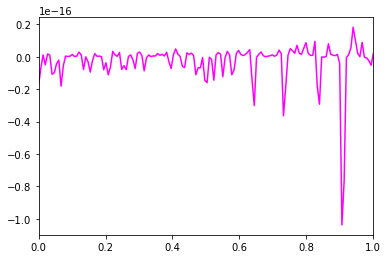

In [10]:
fig, ax = plt.subplots()

plot_grads_restricted(prod_dim100, weights_100, None, False, ax, True, True)

In [11]:
params = grad_sampler.param_values[0].squeeze()
grads = grad_sampler.grads[0].squeeze()

NameError: name 'grad_sampler' is not defined

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(16)
fig.suptitle("Gradient estimators when true output is T")
ax1.set_title("With true parameter w = F")
ax1.set_xlim((0, 1))
ax1.set_ylim((0, 2))
plot_grads(params[sample_cjs][:,weights == False], grads[sample_cjs][:,weights == False], ax1)
ax2.set_title("With true parameter w = T")
ax2.set_xlim((0, 1))
ax2.set_ylim((0, 2))
plot_grads(params[sample_cjs][:,weights], grads[sample_cjs][:,weights], ax2)
fig.tight_layout()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(16)
fig.suptitle("Gradient estimators when true output is F")
ax1.set_title("With true parameter w = F")
ax1.set_xlim((0, 1))
ax1.set_ylim((-2, 0))
plot_grads(params[sample_cjs == False][:,weights == False], grads[sample_cjs == False][:,weights == False], ax1)
ax2.set_title("With true parameter w = T")
ax2.set_xlim((0, 1))
ax2.set_ylim((-2, 0))
plot_grads(params[sample_cjs == False][:,weights], grads[sample_cjs == False][:,weights], ax2)
fig.tight_layout()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(16)
fig.suptitle("Gradient estimators overall")
ax1.set_title("With true parameter w = F")
ax1.set_xlim((0, 1))
plot_grads(params[:,weights == False], grads[:,weights == False], ax1, no_points=True)
ax2.set_title("With true parameter w = T")
ax2.set_xlim((0, 1))
plot_grads(params[:,weights], grads[:,weights], ax2, no_points=True)
fig.tight_layout()

The above results also show that the default behaviour is to slowly ascend parameters to 1, so we would expect parameters with true parameterisation $T$ to be faithfully captured also. We now train a model to verify our expectations.

In [ ]:
optim = torch.optim.Adam(cj_model.parameters(), lr=1e-3)

losses = []
torch.autograd.set_detect_anomaly(True) 

for bs in loader:
    cjs = logic.conjoin(logic.implies(weights, bs), dim=1)
    cj_hats = cj_model(flogic.encode(bs)).squeeze()
    loss = ((cjs.float() - cj_hats) ** 2).mean()
    losses.append(loss.item())
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
losses = torch.Tensor(losses)

In [ ]:
plt.plot(losses)

In [ ]:
((torch.sigmoid(cj_model.weights).squeeze() - weights.float()) ** 2).mean()

The average distance of the learnt parameters is incredibly close to the true ones.

In [ ]:
losses

In [ ]:
cj_model.fuzzy_params()

In [ ]:
prod_dim100